# 第一步： # n_estimators 

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

In [2]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"RentListingInquries_FE_train.csv")
#train.head()

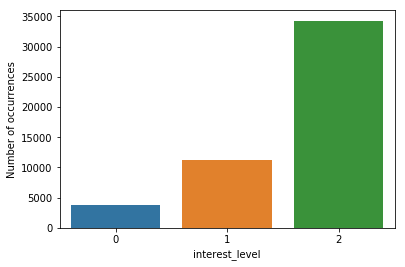

In [3]:
sns.countplot(train.interest_level);
pyplot.xlabel('interest_level');
pyplot.ylabel('Number of occurrences');

In [4]:
y_train = train['interest_level']

train = train.drop([ "interest_level"], axis=1)
X_train = np.array(train)

In [5]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [6]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
def modelfit(alg, X_train, y_train, cv_folds=None, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 3
    
    #直接调用xgboost，而非sklarn的wrapper类
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
  
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        

In [7]:
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 9}
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb1, X_train, y_train, cv_folds = kfold)

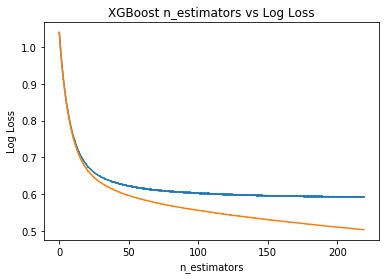

In [8]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')
        
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators4_1.png' )

pyplot.show()

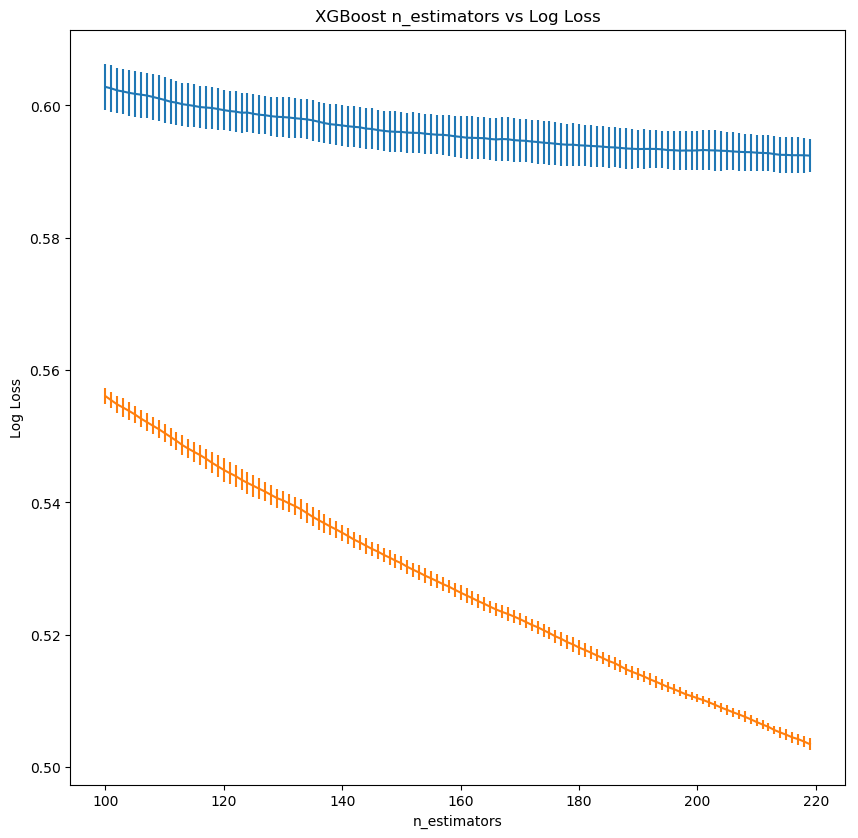

In [9]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')

cvresult = cvresult.iloc[100:]
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(100,cvresult.shape[0]+100)
        
fig = pyplot.figure(figsize=(10, 10), dpi=100)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators_detail.png' )

pyplot.show()

# 第二步：调整树的参数：max_depth & min_child_weight

## 粗调，参数的步长为2

In [10]:
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1

{'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)}

In [11]:
xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=220,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train , y_train)

gsearch2_1.grid_scores_, gsearch2_1.best_params_,     gsearch2_1.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.60221, std: 0.00318, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.60259, std: 0.00328, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.60249, std: 0.00324, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.58874, std: 0.00413, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.58963, std: 0.00368, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.58945, std: 0.00342, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.58914, std: 0.00317, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.58937, std: 0.00370, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.58880, std: 0.00357, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.60226, std: 0.00388, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.59922, std: 0.00566, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.59578, std: 0.00374, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

In [12]:
gsearch2_1.cv_results_

{'mean_fit_time': array([ 130.67238874,  131.98352561,  132.61451693,  184.68806052,
         185.67431464,  183.57305956,  239.40572476,  236.98168225,
         236.4416522 ,  295.57207971,  279.88683572,  246.25015192]),
 'mean_score_time': array([ 0.27534132,  0.2875742 ,  0.27674479,  0.46445031,  0.47287278,
         0.46324687,  0.70509791,  0.65976601,  0.65394793,  1.28463359,
         0.87874861,  0.67419229]),
 'mean_test_score': array([-0.60221355, -0.60258789, -0.60248802, -0.58873519, -0.5896312 ,
        -0.58944899, -0.58913874, -0.58937052, -0.58879567, -0.60226239,
        -0.5992217 , -0.59577645]),
 'mean_train_score': array([-0.57934346, -0.58039194, -0.58062066, -0.51307099, -0.51860785,
        -0.5216289 , -0.41140123, -0.43188637, -0.44436297, -0.28925616,
        -0.33405741, -0.36088415]),
 'param_max_depth': masked_array(data = [3 3 3 5 5 5 7 7 7 9 9 9],
              mask = [False False False False False False False False False False False False],
        fi

Best: -0.588735 using {'max_depth': 5, 'min_child_weight': 1}


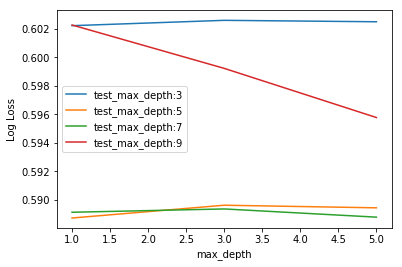

In [13]:
# summarize results
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(max_depth):
    pyplot.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

## 最佳参数周围，将步长降为1，进行精细调整

In [14]:
max_depth = [4,5,6]
min_child_weight = [1,2]
param_test2_2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_2

{'max_depth': [4, 5, 6], 'min_child_weight': [1, 2]}

In [15]:
xgb2_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=220,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch2_2 = GridSearchCV(xgb2_2, param_grid = param_test2_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_2.fit(X_train , y_train)

gsearch2_2.grid_scores_, gsearch2_2.best_params_,     gsearch2_2.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.59333, std: 0.00314, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -0.59334, std: 0.00353, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -0.58874, std: 0.00413, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.58980, std: 0.00291, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: -0.58927, std: 0.00345, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -0.58919, std: 0.00385, params: {'max_depth': 6, 'min_child_weight': 2}],
 {'max_depth': 5, 'min_child_weight': 1},
 -0.58873519032844845)

In [16]:
gsearch2_2.cv_results_

{'mean_fit_time': array([ 160.9340014 ,  160.32860026,  184.85180006,  185.52914729,
         194.93061438,  149.01902113]),
 'mean_score_time': array([ 0.37620564,  0.38542995,  0.46183443,  0.47085857,  0.51457548,
         0.47227731]),
 'mean_test_score': array([-0.59332946, -0.5933389 , -0.58873519, -0.5897995 , -0.58926869,
        -0.58919001]),
 'mean_train_score': array([-0.54978397, -0.55102549, -0.51307099, -0.51601097, -0.46661792,
        -0.47313758]),
 'param_max_depth': masked_array(data = [4 4 5 5 6 6],
              mask = [False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [1 2 1 2 1 2],
              mask = [False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 4, 'min_child_weight': 1},
  {'max_depth': 4, 'min_child_weight': 2},
  {'max_depth': 5, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 2},
  {'max_depth': 6, 'min_child_weight': 1},
  {'max_depth': 6

Best: -0.588735 using {'max_depth': 5, 'min_child_weight': 1}


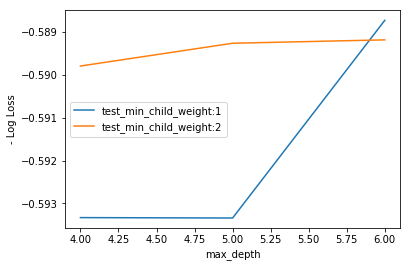

In [18]:
# summarize results
print("Best: %f using %s" % (gsearch2_2.best_score_, gsearch2_2.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_2.csv')

# plot results
test_scores = np.array(test_means).reshape(len(min_child_weight), len(max_depth))
train_scores = np.array(train_means).reshape(len(min_child_weight), len(max_depth))

for i, value in enumerate(min_child_weight):
    pyplot.plot(max_depth, test_scores[i], label= 'test_min_child_weight:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( '- Log Loss' )
pyplot.savefig( 'max_depth_vs_min_child_weght2.png' )

# 第三部 再次调整弱分类器数目

max_depth ，min_child_weight和初始参数设置的参数恰巧相同，不再次调整弱分类器数目



# 第四步：调整树的参数：subsample 和 colsample_bytree

In [19]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
subsample = [i/10.0 for i in range(3,9)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_test3_1 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test3_1


{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

In [20]:
xgb3_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=220,  #第二轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch3_1 = GridSearchCV(xgb3_1, param_grid = param_test3_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch3_1.fit(X_train , y_train)

gsearch3_1.grid_scores_, gsearch3_1.best_params_,     gsearch3_1.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.59017, std: 0.00373, params: {'colsample_bytree': 0.6, 'subsample': 0.3},
  mean: -0.58785, std: 0.00399, params: {'colsample_bytree': 0.6, 'subsample': 0.4},
  mean: -0.58639, std: 0.00301, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -0.58574, std: 0.00326, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.58558, std: 0.00323, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.58481, std: 0.00278, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.58911, std: 0.00396, params: {'colsample_bytree': 0.7, 'subsample': 0.3},
  mean: -0.58772, std: 0.00400, params: {'colsample_bytree': 0.7, 'subsample': 0.4},
  mean: -0.58590, std: 0.00399, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
  mean: -0.58557, std: 0.00404, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.58492, std: 0.00388, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.58473, std: 0.00406, params: {'colsample_bytree': 0.7,

In [21]:
gsearch3_1.cv_results_

{'mean_fit_time': array([ 154.82052274,  171.98911052,  182.85344944,  185.44073043,
         188.04829063,  187.78722744,  169.75595727,  193.07552528,
         202.16014404,  208.65907021,  203.41809797,  202.20967655,
         185.69765658,  207.1480412 ,  224.61332645,  225.73534837,
         227.18816004,  224.81253433,  200.6162281 ,  226.35544763,
         242.60556903,  250.84112449,  238.74567842,  217.72485509]),
 'mean_score_time': array([ 0.46784706,  0.45421104,  0.4600266 ,  0.45962572,  0.4530076 ,
         0.47506661,  0.45581532,  0.45461216,  0.45381007,  0.45681791,
         0.45380993,  0.45300775,  0.4656415 ,  0.46624355,  0.46303468,
         0.45641689,  0.45962539,  0.45721893,  0.4580214 ,  0.45761986,
         0.45882339,  0.45401053,  0.40347605,  0.35433998]),
 'mean_test_score': array([-0.59017335, -0.58785269, -0.58639471, -0.58574306, -0.58557778,
        -0.58481374, -0.58911289, -0.58772162, -0.58590311, -0.58556903,
        -0.58491781, -0.58473211, -

Best: -0.583948 using {'colsample_bytree': 0.9, 'subsample': 0.8}


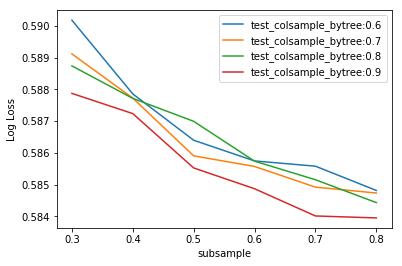

In [22]:
# summarize results
print("Best: %f using %s" % (gsearch3_1.best_score_, gsearch3_1.best_params_))
test_means = gsearch3_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch3_1.cv_results_[ 'std_test_score' ]
train_means = gsearch3_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch3_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch3_1.cv_results_).to_csv('my_preds_subsampleh_colsample_bytree_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(colsample_bytree), len(subsample))
train_scores = np.array(train_means).reshape(len(colsample_bytree), len(subsample))

for i, value in enumerate(colsample_bytree):
    pyplot.plot(subsample, -test_scores[i], label= 'test_colsample_bytree:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'subsample' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'subsample_vs_colsample_bytree1.png' )

In [30]:
reg_alpha = [ 0.1,1,1.5,2]    #default = 0, 测试0.1,1，1.5，2
reg_lambda = [0.1,0.5,1,2]      #default = 1，测试0.1， 0.5， 1，2

param_test5_1 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
param_test5_1

{'reg_alpha': [0.1, 1, 1.5, 2], 'reg_lambda': [0.1, 0.5, 1, 2]}

In [31]:
xgb5_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=220,  #第二轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.9,
        colsample_bylevel = 0.8,
        objective= 'multi:softprob',
        seed=3)


gsearch5_1 = GridSearchCV(xgb5_1, param_grid = param_test5_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch5_1.fit(X_train , y_train)

gsearch5_1.grid_scores_, gsearch5_1.best_params_,     gsearch5_1.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58410, std: 0.00421, params: {'reg_alpha': 0.1, 'reg_lambda': 0.1},
  mean: -0.58428, std: 0.00461, params: {'reg_alpha': 0.1, 'reg_lambda': 0.5},
  mean: -0.58417, std: 0.00432, params: {'reg_alpha': 0.1, 'reg_lambda': 1},
  mean: -0.58409, std: 0.00392, params: {'reg_alpha': 0.1, 'reg_lambda': 2},
  mean: -0.58325, std: 0.00407, params: {'reg_alpha': 1, 'reg_lambda': 0.1},
  mean: -0.58327, std: 0.00485, params: {'reg_alpha': 1, 'reg_lambda': 0.5},
  mean: -0.58350, std: 0.00403, params: {'reg_alpha': 1, 'reg_lambda': 1},
  mean: -0.58342, std: 0.00421, params: {'reg_alpha': 1, 'reg_lambda': 2},
  mean: -0.58375, std: 0.00396, params: {'reg_alpha': 1.5, 'reg_lambda': 0.1},
  mean: -0.58338, std: 0.00391, params: {'reg_alpha': 1.5, 'reg_lambda': 0.5},
  mean: -0.58375, std: 0.00419, params: {'reg_alpha': 1.5, 'reg_lambda': 1},
  mean: -0.58385, std: 0.00416, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.58365, std: 0.00391, params: {'reg_alpha': 2, 'reg_lambda': 0

In [32]:
gsearch5_1.cv_results_

{'mean_fit_time': array([ 271.26822953,  272.1853931 ,  269.78279548,  271.19197998,
         271.23689957,  269.96832566,  272.87625899,  271.34418483,
         271.14645886,  274.93152466,  270.4327611 ,  273.45499835,
         270.84746389,  271.77392759,  238.76334314,  212.62102318]),
 'mean_score_time': array([ 0.46403432,  0.45581255,  0.45621347,  0.47566538,  0.45962238,
         0.46323242,  0.46964917,  0.46242995,  0.45922136,  0.46944861,
         0.47767034,  0.47065172,  0.46323242,  0.46243005,  0.40828533,
         0.37459626]),
 'mean_test_score': array([-0.58409811, -0.58428493, -0.58416873, -0.58409328, -0.58324988,
        -0.58326981, -0.58350444, -0.58341607, -0.58374585, -0.58338314,
        -0.58374597, -0.5838487 , -0.58365295, -0.58370988, -0.58347432,
        -0.58441006]),
 'mean_train_score': array([-0.49970638, -0.50170367, -0.5040307 , -0.50647275, -0.5014967 ,
        -0.50341921, -0.5052699 , -0.50714709, -0.50431138, -0.50555805,
        -0.50662305, 

Best: -0.583250 using {'reg_alpha': 1, 'reg_lambda': 0.1}


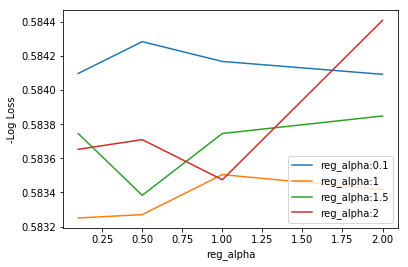

In [33]:
# summarize results
print("Best: %f using %s" % (gsearch5_1.best_score_, gsearch5_1.best_params_))
test_means = gsearch5_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch5_1.cv_results_[ 'std_test_score' ]
train_means = gsearch5_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch5_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch5_1.cv_results_).to_csv('my_preds_reg_alpha_reg_lambda_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(reg_alpha), len(reg_lambda))
train_scores = np.array(train_means).reshape(len(reg_alpha), len(reg_lambda))

#log_reg_alpha = [0,0,0,0]
#for index in range(len(reg_alpha)):
#   log_reg_alpha[index] = math.log10(reg_alpha[index])
    
for i, value in enumerate(reg_alpha):
    pyplot.plot(reg_lambda, -test_scores[i], label= 'reg_alpha:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'reg_alpha' )                                                                                                      
pyplot.ylabel( '-Log Loss' )
pyplot.savefig( 'reg_alpha_vs_reg_lambda1.png' )

# 结果保存

In [37]:
test = pd.read_csv(dpath +"RentListingInquries_FE_test.csv")

X_test = np.array(test)

Y_test = gsearch5_1.predict(X_test)

test['interest_level'] = Y_test
test.to_csv("result.csv", index =False)

